In [16]:
import pandas as pd
import datetime as dt
import numpy as np
import glob
import re

holidays = [dt.date(2020,12,31),dt.date(2021,1,1),dt.date(2021,1,2), dt.date(2021,1,3), dt.date(2021,1,4), dt.date(2021,1,5), 
            dt.date(2021,1,6), dt.date(2021,1,7), dt.date(2021,1,8), dt.date(2021,1,9), dt.date(2021,1,10), dt.date(2021,2,22),
            dt.date(2021,2,23), dt.date(2021,3,8), dt.date(2021,5,3),dt.date(2021,5,4), dt.date(2021,5,5), dt.date(2021,5,6), 
            dt.date(2021,5,7), dt.date(2021,5,10), dt.date(2021,11,4), dt.date(2021,11,5)]

def preprocess_dataframe(dataframe,tag):
    dataframe['Время звонка']=dataframe['Время звонка'].astype('str')
    dataframe['Время ожидания']=pd.to_timedelta(dataframe['Время ожидания'].astype('str'))
    dataframe['Время разговора']=pd.to_timedelta(dataframe['Время разговора'].astype('str'))
    
    dataframe=dataframe.groupby((dataframe[['Номер телефона']].isnull()==False).all(1).cumsum()).agg({'Время звонка': ' '.join, 'Номер телефона': 'first', 'Статус звонка': 'first',
                  'Время ожидания': 'first', 'Время разговора': 'first',
                  'Группа': 'first', 'Оператор': 'first'})
    
    dataframe['Время звонка']=dataframe['Время звонка'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S %Y-%m-%d 00:00:00'))
    dataframe['Дата звонка']=dataframe['Время звонка'].dt.date
    dataframe['День недели']=dataframe['Время звонка'].apply(lambda x: x.weekday())
    dataframe['Час звонка']=dataframe['Время звонка'].dt.hour
    dataframe['Время звонка']=dataframe['Время звонка'].dt.time
    
    dataframe['Время ожидания']=dataframe['Время ожидания'].apply(lambda x: x.total_seconds()/60)
    dataframe['Время разговора']=dataframe['Время разговора'].apply(lambda x: x.total_seconds()/60)
    
    dataframe['Тип']=tag
    dataframe['Оператор']= dataframe['Оператор'].replace({np.nan:None})
    if (tag=='vmk'):
        #tmp_df=dataframe[(dataframe['Группа']!='Общая')]
        #tmp_df2=dataframe[dataframe['Группа']=='Общая']
        
        if (dataframe['Дата звонка'].values[0] in holidays):
            dataframe=dataframe[(dataframe['Час звонка']>=0) & (dataframe['Час звонка']<24)]
        else:
            dataframe=dataframe[(dataframe['Час звонка']>=0) & (((dataframe['День недели']<7) & (dataframe['Час звонка']<24)) | ((dataframe['День недели']>=5) & (dataframe['Час звонка']<14)))]
        
        #dataframe=pd.concat([tmp_df,tmp_df2])
        #dataframe['Оператор']=dataframe['Оператор'].apply(lambda x: str(x)+' (vmk)' if not x is None else None)
    
    return dataframe

def calculate_statistics2(dataframe):
    tmp=dataframe[(dataframe['Тип']=='call_center') & (dataframe['Оператор'].notna()) & (dataframe['Статус звонка']!='Не дождался')]
    call_center_volont_day=len(tmp[(tmp['Час звонка']>=0) & (tmp['Час звонка']<24)]['Оператор'].unique())
    call_center_volont_night=len(tmp[(tmp['Час звонка']<0) | (tmp['Час звонка']>=24)]['Оператор'].unique())
    vmk_volont=len(dataframe[(dataframe['Тип']=='vmk') & (dataframe['Оператор'].notna()) & (dataframe['Статус звонка']!='Не дождался')]['Оператор'].unique())
    print(vmk_volont,call_center_volont_day)
    
    all_night_calls=dataframe[(dataframe['Час звонка']<0) | (dataframe['Час звонка']>=24)].shape[0]
    
    all_calls=dataframe.shape[0]
    missed_calls=dataframe[dataframe["Статус звонка"]=='Не дождался'].shape[0]
    mean_talk=np.round(dataframe['Время разговора'].mean(),1)
    max_wait=np.round(dataframe['Время ожидания'].max(),1)
    group_with_max_wait=dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]['Группа'].values[0]
    time_with_max_wait=dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]['Время звонка'].values[0]
    
    mean_wait=np.round(dataframe['Время ожидания'].mean(),1)
    more_3_min=dataframe[dataframe['Время ожидания']>=3].shape[0]
    to_doctor=dataframe[(dataframe['Группа']=='Медколледж') | (dataframe['Группа']=='Волжский')].shape[0]
    other=dataframe[dataframe['Группа']=='Облкомобразования'].shape[0]
    
    print('Число операторов всего: {0}'.format(call_center_volont_day+call_center_volont_night+vmk_volont))
    print('Число операторов днем: {0}'.format(call_center_volont_day+vmk_volont))
    print('Число операторов ночью: {0} (ночью позвонили {1} раз)'.format(call_center_volont_night,all_night_calls))
    
    print('Количество звонков по COVID-19: {0}'.format(all_calls))
    print('Неотвеченных вызовов, шт.: {0}'.format(missed_calls))
    print('Среднее время разговора (мин): {0}'.format(mean_talk))
    print('Максимальное время ожидания (мин): {0} ({1},{2})'.format(max_wait,group_with_max_wait,time_with_max_wait))
    print('Среднее время ожидания (мин): {0}'.format(mean_wait))
    print('Ожидание более 3 минут (%): {0}'.format(np.round(more_3_min*100/all_calls,0)))
    print('Запись к врачу (%): {0}'.format(np.round(to_doctor*100/all_calls,0)))
    print('Иное (%): {0}'.format(100-np.round(to_doctor*100/all_calls,0)))

names1 = glob.glob('../Недозвоны/Колл-центр COVID-19/*', recursive=True)
names2= glob.glob('../Недозвоны/ВМК/*', recursive=True)
names3= glob.glob('../Недозвоны/Волжский/*', recursive=True)
cont = []

for i in range(len(names1)):
    df = pd.read_excel(names1[i])
    df=preprocess_dataframe(df,'call_center')
    match = re.search(r'\d{4}-\d{2}-\d{2}', names1[i])
    df['Отчетная дата'] = dt.datetime.strptime(match.group(), '%Y-%m-%d').date()
    cont.append(df)
    
for i in range(len(names2)): 
    if names2[i]!='../Недозвоны/ВМК\~$2021-02-19.xlsx':
        
        #print(names2[i])
        df = pd.read_excel(names2[i])
        df=preprocess_dataframe(df,'vmk')
        match = re.search(r'\d{4}-\d{2}-\d{2}', names2[i])
        df['Отчетная дата'] = dt.datetime.strptime(match.group(), '%Y-%m-%d').date()
        cont.append(df)
    
for i in range(len(names3)):
    df = pd.read_excel(names3[i],usecols=['Дата вызова','Время вызова','Номер вызывающего','Статус'])
    df=df.rename(columns={'Дата вызова':'Дата звонка','Время вызова':'Время звонка','Статус':'Статус звонка','Номер вызывающего':'Номер телефона'})
    df['Время ожидания']=None
    df['Время разговора']=None
    df['Время ожидания']=df['Время ожидания'].astype('float')
    df['Время разговора']=df['Время разговора'].astype('float')
    df['Группа']='Волжский'
    df['Оператор']=None
    df['Время звонка']=pd.to_datetime(df['Время звонка'])
    df['Дата звонка']=pd.to_datetime(df['Дата звонка'])
    df['День недели']=df['Дата звонка'].apply(lambda x: x.weekday())
    df['Час звонка']=df['Время звонка'].dt.hour
    df['Тип']='vmk'
    df['Время звонка']=df['Время звонка'].dt.time
    df['Дата звонка']=df['Дата звонка'].dt.date
    
    if (df['Дата звонка'].values[0] in holidays):
        df=df[(df['Час звонка']>=8) & (df['Час звонка']<14)]
    else:
        df=df[(df['Час звонка']>=8) & (((df['День недели']<5) & (df['Час звонка']<18)) | ((df['День недели']>=5) & (df['Час звонка']<14)))]
    
    df['Статус звонка']=df['Статус звонка'].replace({'пропущенный':None,'успешный':None})
    match = re.search(r'\d{4}-\d{2}-\d{2}', names3[i])
    df['Отчетная дата'] = dt.datetime.strptime(match.group(), '%Y-%m-%d').date()
    cont.append(df)


total_all_days = pd.concat(cont)
total_all_days['Группа']=total_all_days['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования'})

In [17]:
#day=dt.date.today()
day=dt.date(2022,5,19)
calculate_statistics2(total_all_days[total_all_days['Отчетная дата']==day])

22 0
Число операторов всего: 22
Число операторов днем: 22
Число операторов ночью: 0 (ночью позвонили 0 раз)
Количество звонков по COVID-19: 193
Неотвеченных вызовов, шт.: 6
Среднее время разговора (мин): 3.0
Максимальное время ожидания (мин): 0.8 (Медколледж,10:20:30)
Среднее время ожидания (мин): 0.1
Ожидание более 3 минут (%): 0.0
Запись к врачу (%): 100.0
Иное (%): 0.0


In [18]:
total_all_days[total_all_days['Отчетная дата']==day].sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания', 'Группа', 'Оператор', 'Статус звонка']].head(50)
#table1 = total_all_days[total_all_days['Отчетная дата']==day].sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания', 'Группа', 'Оператор', 'Статус звонка']].head(150)
#table1.to_excel("Сортировка по времени ожидания.xlsx")

,Дата звонка,Время звонка,Время ожидания,Группа,Оператор,Статус звонка
54,2022-05-18,10:20:30,0.783333,Медколледж,user110,Завершён оператором
117,2022-05-18,13:23:58,0.783333,Медколледж,user101,Завершён оператором
50,2022-05-18,10:10:41,0.766667,Медколледж,user112,Переведён
116,2022-05-18,13:21:39,0.750000,Медколледж,user101,Не дождался
119,2022-05-18,13:48:24,0.733333,Медколледж,user111,Завершён абонентом
51,2022-05-18,10:11:42,0.666667,Медколледж,user100,Не дождался
164,2022-05-18,15:44:40,0.466667,Медколледж,user111,Завершён оператором
143,2022-05-18,15:06:02,0.333333,Медколледж,user106,Переведён
177,2022-05-18,16:23:56,0.316667,Медколледж,user111,Завершён оператором
95,2022-05-18,12:13:32,0.316667,Медколледж,user101,Завершён оператором


In [19]:
df['Дата звонка']=pd.to_datetime(df['Дата звонка'])
df=df[(df['Дата звонка'] > '2021-01-01') & (df['Дата звонка'] < '2021-03-31')]
print (df)


Empty DataFrame
Columns: [Дата звонка, Время звонка, Номер телефона, Статус звонка, Время ожидания, Время разговора, Группа, Оператор, День недели, Час звонка, Тип, Отчетная дата]
Index: []


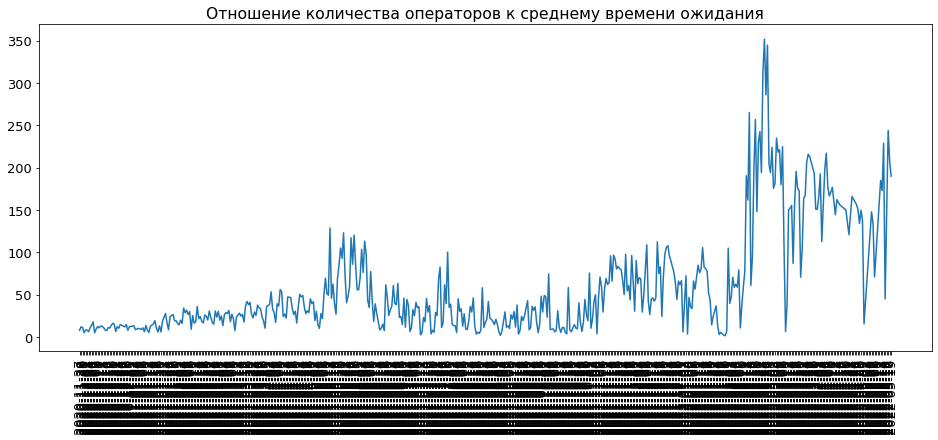

In [20]:
import matplotlib.pyplot as plt
temp = total_all_days.groupby('Отчетная дата').agg({'Оператор': ['nunique'],'Время ожидания':['mean']}).reset_index()
temp2 = total_all_days[total_all_days['Статус звонка']=='Не дождался'].groupby('Отчетная дата').agg({'Дата звонка':['count']}).reset_index()
temp=temp.merge(temp2)
temp.columns=temp.columns.droplevel(1)
temp.columns=['Дата','Количество операторов','Среднее время ожидания','Количество недозвонов']

f = plt.figure(figsize=(16,6))
#plt.plot(temp['Дата'], temp['Количество операторов']/temp['Количество недозвонов'])
plt.plot(temp['Дата'], temp['Количество операторов']/temp['Среднее время ожидания'])

#plt.title('Отношение количества операторов к количеству неотвеченных вызовов')
plt.title('Отношение количества операторов к среднему времени ожидания')

plt.rcParams.update({'font.size': 13})
plt.xticks(pd.date_range(start=temp['Дата'].min(), end=temp['Дата'].max()))
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.show()

f.savefig('Отношение количества операторов к среднему времени ожидания.png', dpi=600)

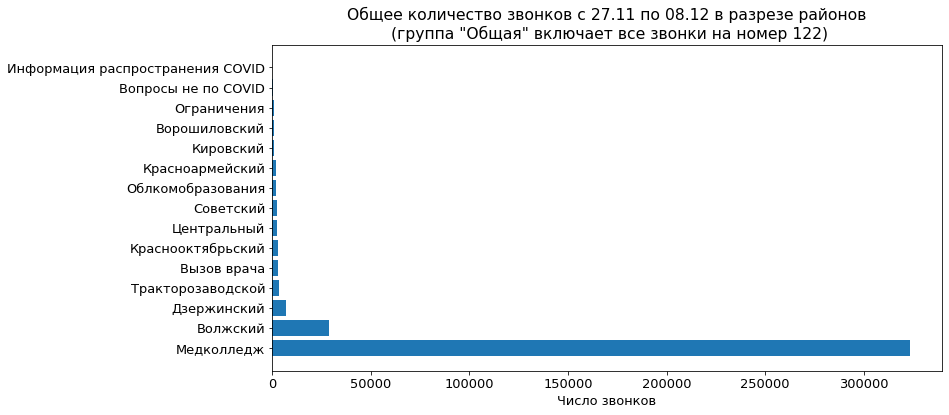

In [21]:
import matplotlib.pyplot as plt
tmp=total_all_days[total_all_days['Тип']=='vmk'].groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)

f = plt.figure(figsize=(12,6))
plt.barh(tmp['Группа'], tmp['Число звонков'],label='Общее количество звонков')

plt.xlabel('Число звонков')
plt.title('Общее количество звонков с 27.11 по 08.12 в разрезе районов\n (группа "Общая" включает все звонки на номер 122)')

plt.rcParams.update({'font.size': 13})
plt.show()

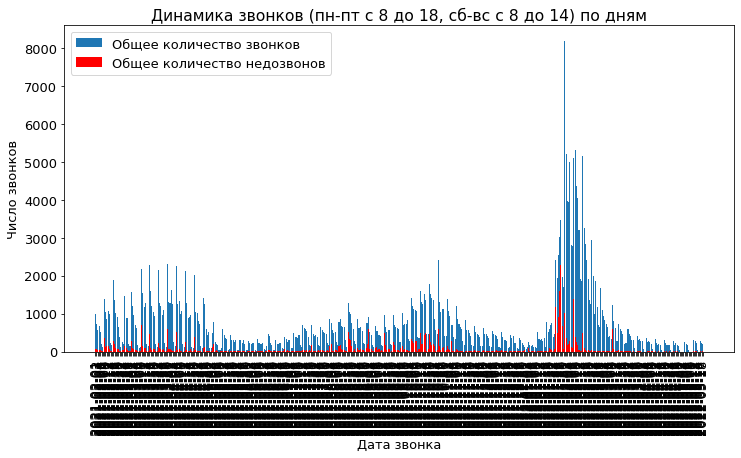

In [22]:
import matplotlib.pyplot as plt

#name='Медколледж'

tmp=total_all_days[(total_all_days['Дата звонка']>=dt.date(2021,2,1))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
tmp2=total_all_days [ (total_all_days['Статус звонка']=='Не дождался') & (total_all_days['Дата звонка']>=dt.date(2021,2,1))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(12,6))
plt.bar(tmp['Дата звонка'], tmp['Число звонков'],label='Общее количество звонков')
plt.bar(tmp2['Дата звонка'], tmp2['Число звонков'],label='Общее количество недозвонов',color='red')

plt.xlabel('Дата звонка')
plt.ylabel('Число звонков')
plt.title('Динамика звонков (пн-пт с 8 до 18, сб-вс с 8 до 14) по дням')

plt.xticks(pd.date_range(start=tmp['Дата звонка'].min(), end=tmp['Дата звонка'].max()))
plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

In [23]:
tmp=total_all_days[(total_all_days['Дата звонка']>=dt.date(2021,1,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,7))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
tmp2=total_all_days [ (total_all_days['Статус звонка']!='Не дождался') & (total_all_days['Дата звонка']>=dt.date(2021,1,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,7))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
Total = tmp2['Число звонков'].sum()

print(tmp2)
print(Total)


   Дата звонка  Число звонков
0   2021-01-01            234
1   2021-01-02            401
2   2021-01-03            498
3   2021-01-04            787
4   2021-01-05            822
..         ...            ...
92  2021-04-03            233
93  2021-04-04            141
94  2021-04-05           1738
95  2021-04-06           1192
96  2021-04-07           1249

[97 rows x 2 columns]
72703


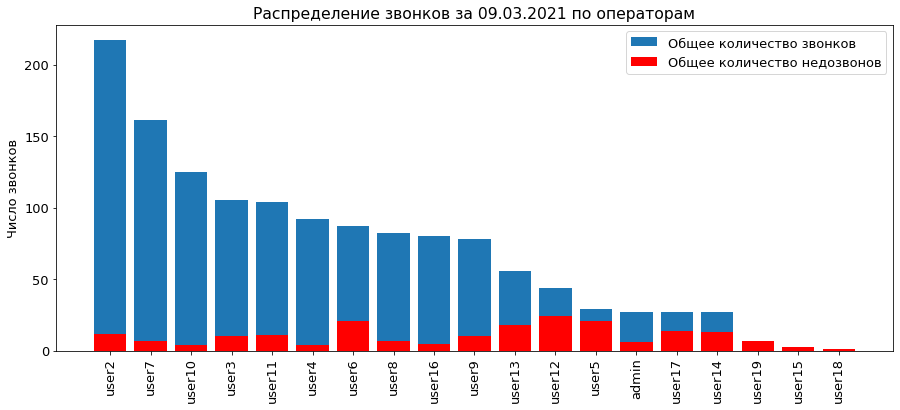

In [24]:
t1=total_all_days[(total_all_days['Отчетная дата']==dt.date(2021,3,10))]
                  #& (total_all_days['Тип']=='vmk')]

tmp=t1.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

tmp2=t1[t1['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(15,6))
plt.bar(tmp['Оператор'], tmp['Число звонков'],label='Общее количество звонков')
plt.bar(tmp2['Оператор'], tmp2['Число звонков'],label='Общее количество недозвонов',color='red')

plt.ylabel('Число звонков')
plt.title('Распределение звонков за 09.03.2021 по операторам')

plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

C:\Users\AdminIS\AppData\Local\Temp/ipykernel_6524/2287687475.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Оператор']=tmp['Оператор'].fillna('Не определен')


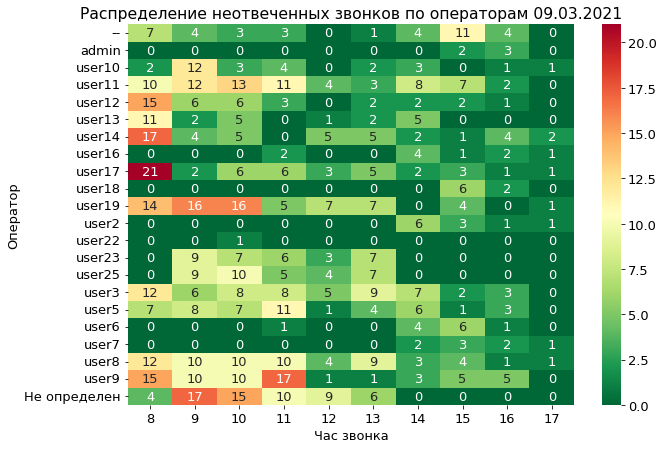

In [25]:
import seaborn as sns
tmp=total_all_days[ (total_all_days['Отчетная дата']==dt.date(2021,5,5))]
#tmp=total_all_days[ (total_all_days['Отчетная дата']==dt.date(2021,2,17))]
#(total_all_days['Тип']=='vmk')
                   #& (total_all_days['Статус звонка']!='Не дождался')]
tmp['Оператор']=tmp['Оператор'].fillna('Не определен')


f = plt.figure(figsize=(10,7))
heatmap_plot = sns.heatmap(pd.crosstab(tmp['Оператор'], tmp['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Распределение неотвеченных звонков по операторам 09.03.2021')

plt.show()

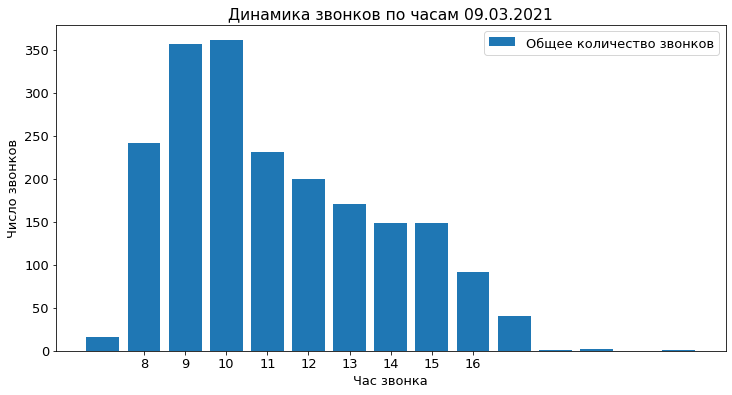

In [26]:
tmp=total_all_days[ (total_all_days['Отчетная дата']==dt.date(2021,3,10))].groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
#(total_all_days['Тип']=='vmk')
f = plt.figure(figsize=(12,6))
plt.bar(tmp['Час звонка'], tmp['Число звонков'],label='Общее количество звонков')

plt.xlabel('Час звонка')
plt.ylabel('Число звонков')
plt.title('Динамика звонков по часам 09.03.2021')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(8,17,1))
plt.legend()
plt.show()

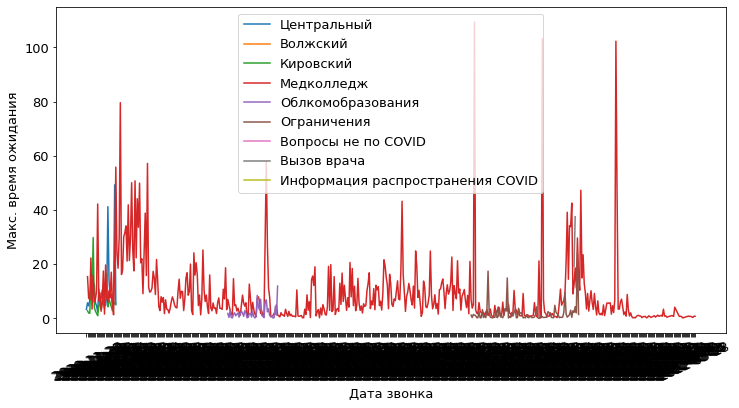

In [27]:
tmp=total_all_days[total_all_days['Тип']=='vmk'].groupby(['Дата звонка','Группа'])['Время ожидания'].max().reset_index(name="Макс. время ожидания")

f = plt.figure(figsize=(12,6))

for name in tmp['Группа'].unique()[6:]:
    
    tmp2=tmp[tmp['Группа']==name]
    plt.plot(tmp2['Дата звонка'], tmp2['Макс. время ожидания'],label=name)

    
plt.xlabel('Дата звонка')
plt.ylabel('Макс. время ожидания')
#plt.title('Динамика максимального времени ожидания')

plt.rcParams.update({'font.size': 13})
plt.xticks(pd.date_range(start=tmp['Дата звонка'].min(), end=tmp['Дата звонка'].max()))
plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 25) 
plt.legend()
plt.show()

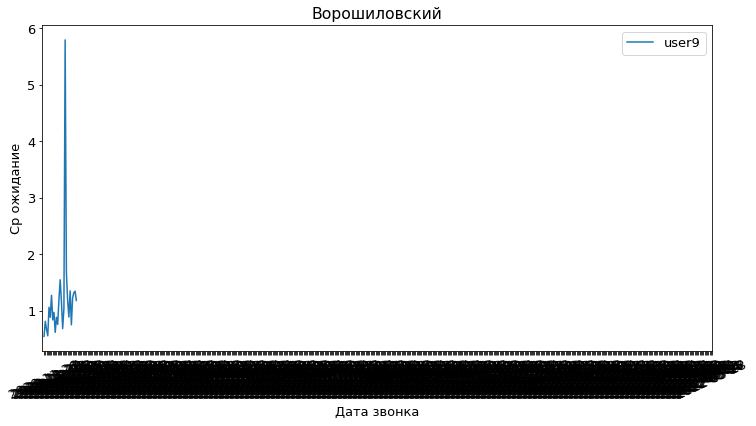

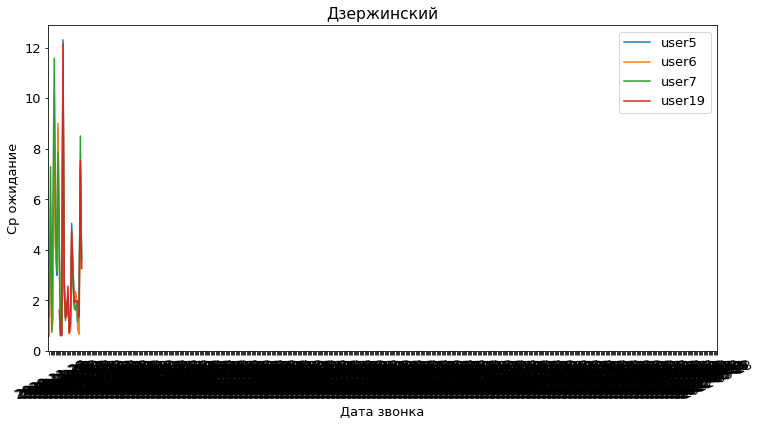

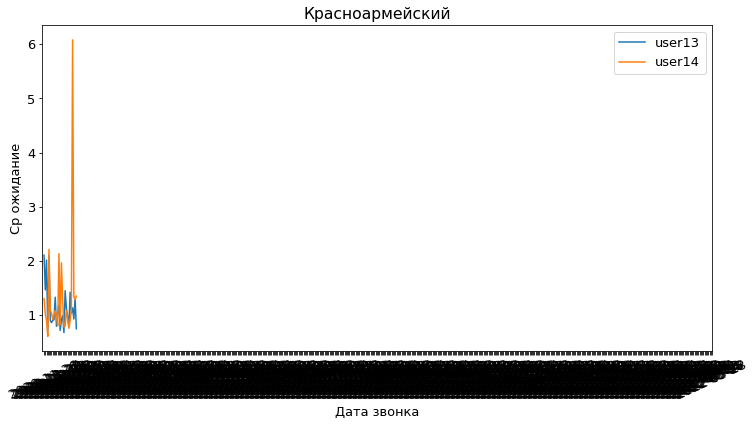

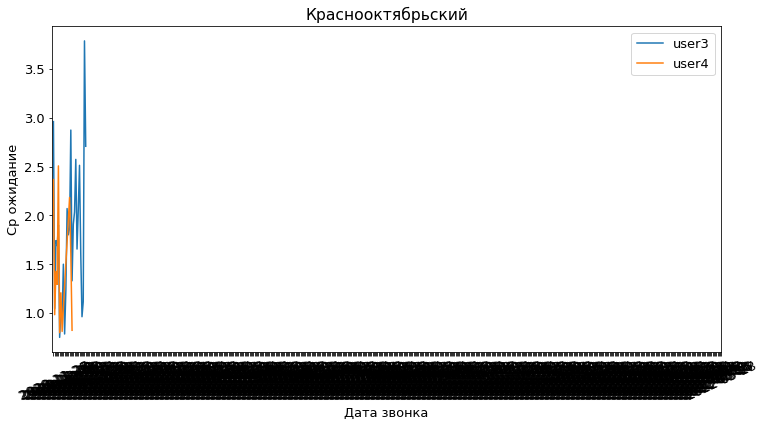

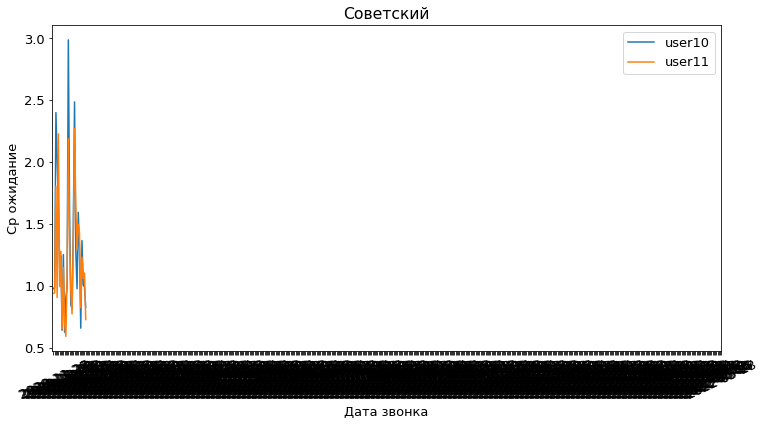

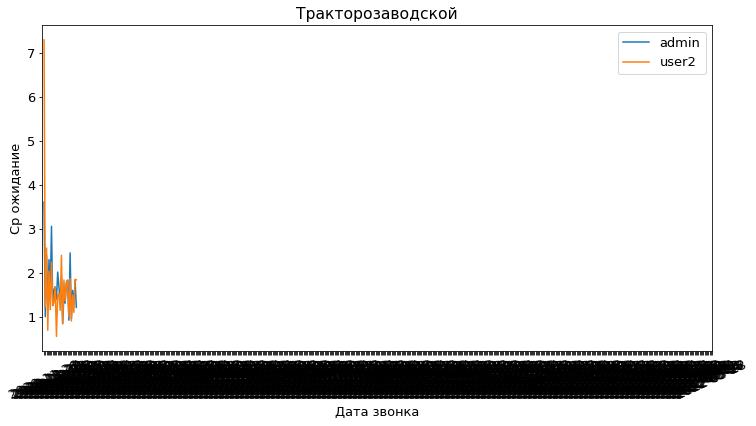

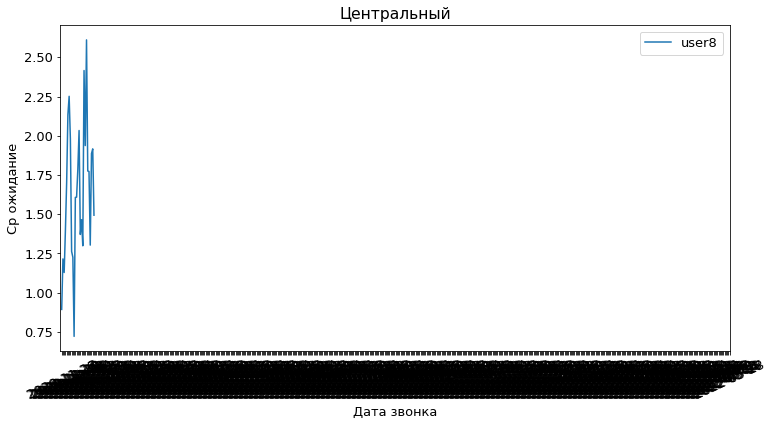

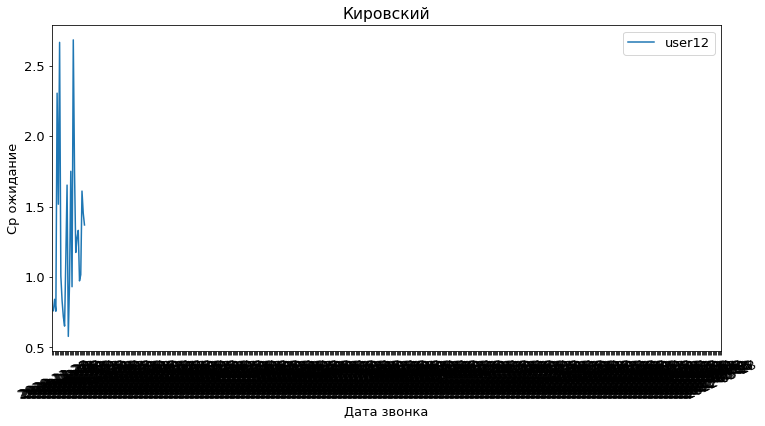

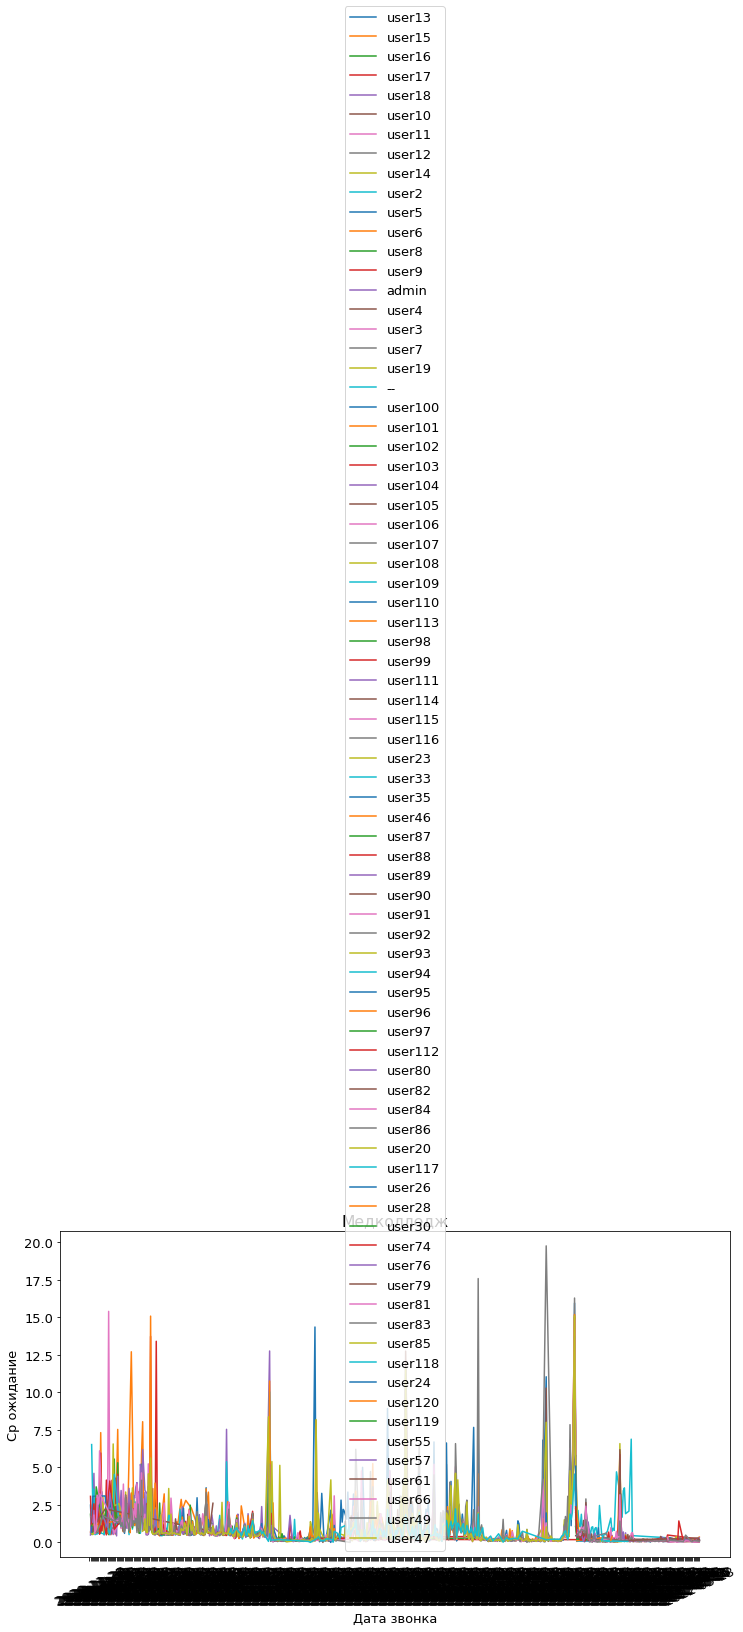

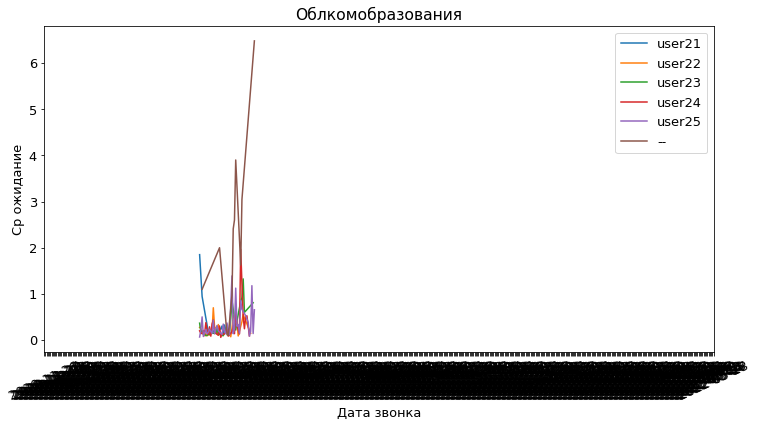

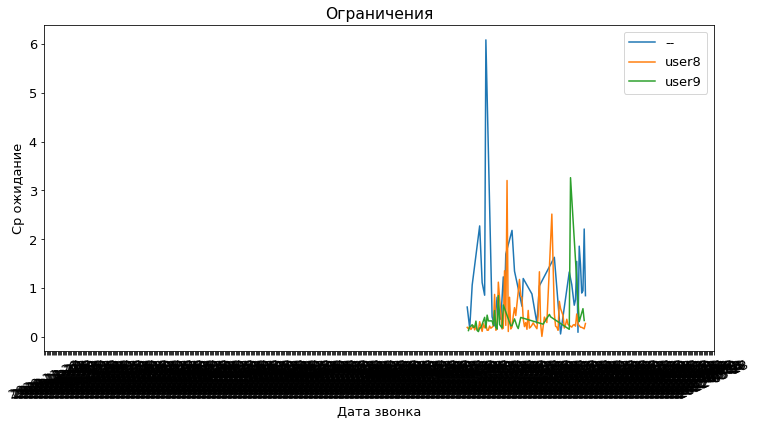

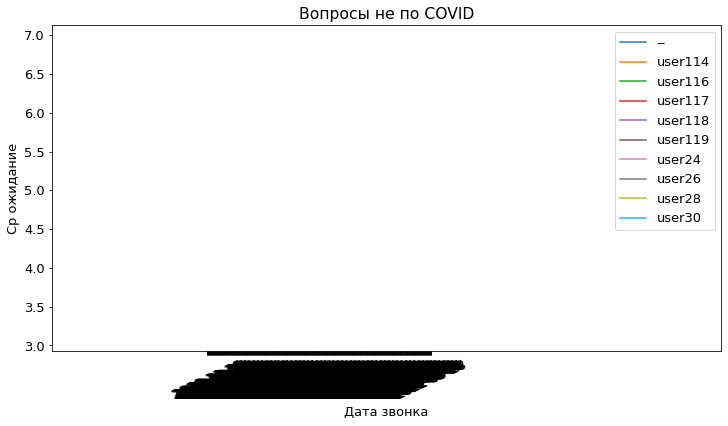

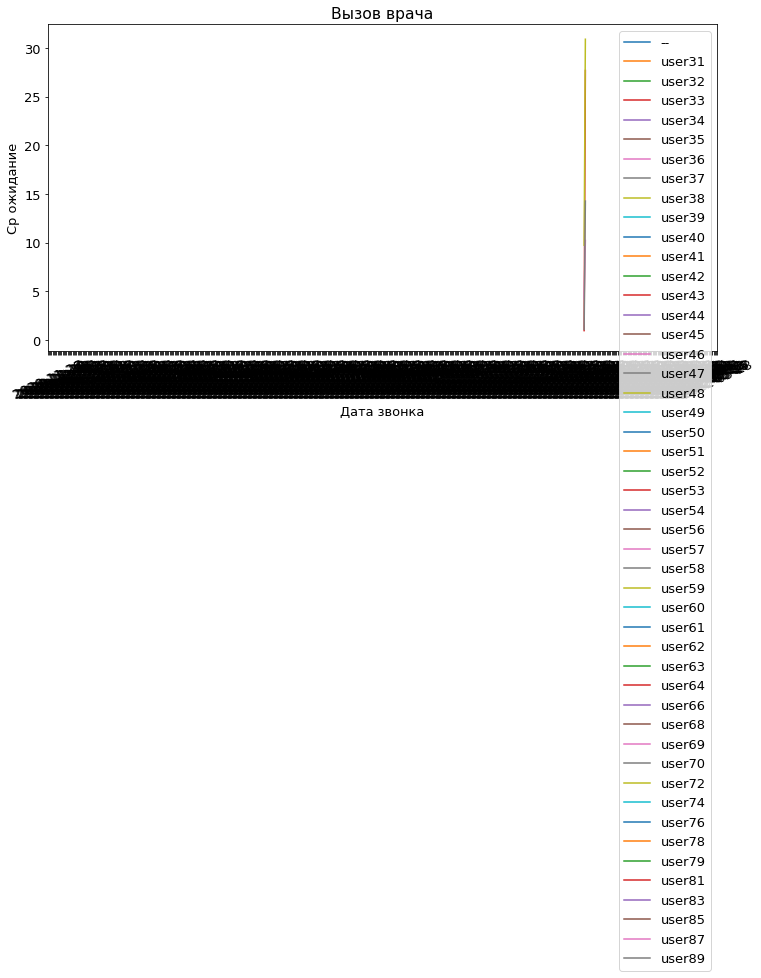

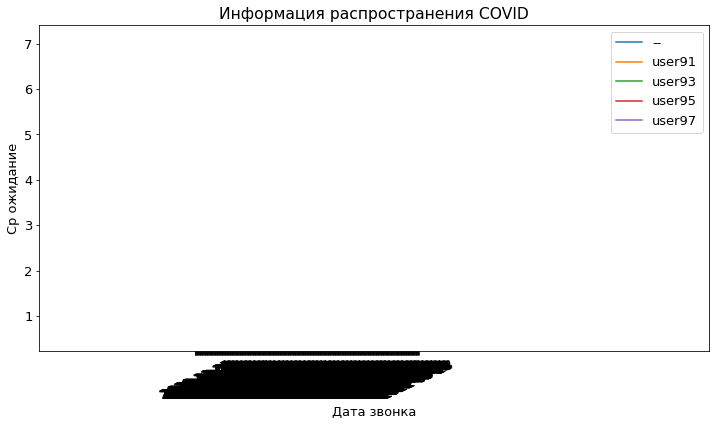

In [28]:
tmp=total_all_days[total_all_days['Тип']=='vmk']
tmp=tmp.groupby(['Дата звонка','Группа','Оператор'])['Время ожидания'].mean().reset_index(name="Ср ожидание")

for name in tmp['Группа'].unique():
    f = plt.figure(figsize=(12,6))
    tmp2=tmp[tmp['Группа']==name]
    for op in tmp2['Оператор'].unique():
        tmp3=tmp2[tmp2['Оператор']==op]
        plt.plot(tmp3['Дата звонка'], tmp3['Ср ожидание'],label=op)

    
    plt.xlabel('Дата звонка')
    plt.ylabel('Ср ожидание')
    plt.title(name)

    plt.rcParams.update({'font.size': 13})
    plt.xticks(pd.date_range(start=tmp['Дата звонка'].min(), end=tmp['Дата звонка'].max()))
    plt.rcParams.update({'font.size': 13})
    plt.gca().xaxis.set_tick_params(rotation = 25) 
    plt.legend()
    plt.show()

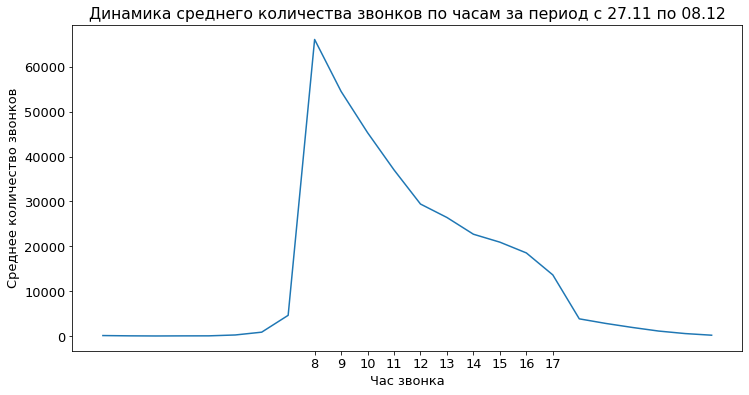

In [29]:
tmp=total_all_days[total_all_days['Тип']=='vmk']
tmp=tmp.groupby(['Час звонка'])['Время ожидания'].count().reset_index(name='Количество звонков')
tmp['Количество звонков']=tmp['Количество звонков']

f = plt.figure(figsize=(12,6))
plt.plot(tmp['Час звонка'], tmp['Количество звонков'])

    
plt.xlabel('Час звонка')
plt.ylabel('Среднее количество звонков')
plt.title('Динамика среднего количества звонков по часам за период с 27.11 по 08.12')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(8,18,1))
#plt.legend()
plt.show()

In [30]:
tmp=total[total['Тип']=='vmk'].groupby('Статус звонка')['Дата звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(10,6))
explode = (0, 0, 0.1)
plt.pie(tmp['Число звонков'],labels=tmp['Статус звонка'],autopct='%1.1f%%',colors=['lightblue','lightgreen','red'],explode=explode)

plt.title('Распределение статусов вызовов по операторам ВМК')
plt.rcParams.update({'font.size': 15})
plt.show()

NameError: name 'total' is not defined

In [ ]:
temp=total_all_days[(total_all_days['Тип']=='vmk') & (total_all_days['Отчетная дата']==dt.date.today())][['Группа','Оператор','Время ожидания','Время звонка']]
temp['Оператор']=temp['Оператор'].fillna('Не определен')

t1=temp.groupby(['Группа','Оператор'])['Время звонка'].count().reset_index(name="Число звонков")
t2=temp.groupby(['Группа','Оператор'])['Время ожидания'].mean().round(1).reset_index(name="Среднее время ожидания (мин)")
t3=temp.groupby(['Группа','Оператор'])['Время ожидания'].max().round(1).reset_index(name="Максимальное время ожидания (мин)")

rez=t1.merge(t2).merge(t3)
rez=rez.sort_values(by='Число звонков',ascending=False)
#rez.to_excel('Операторы '+date_for_statistics+'.xlsx' )
#temp.info()